In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms.v2 as T
import tqdm
import wandb
import cv2
import skdim
import torchvision

sys.path.insert(0, os.path.abspath("python_packages"))
from python_packages import *
from src import *


train_transform = T.Compose([T.ToImage(), T.ToDtype(torch.float32, scale=True), T.Normalize(mean=[781.0543, 781.0543, 781.0543],std=[1537.8235, 1537.8235, 1537.8235]),T.RandomHorizontalFlip(p=0.5),T.RandomVerticalFlip(p=0.5)])
transform = T.Compose([T.ToImage(),T.ToDtype(torch.float32, scale=True),T.Normalize(mean=[781.0543, 781.0543, 781.0543],std=[1537.8235, 1537.8235, 1537.8235],),])


# Getting inner features and predictions for test dataset with trained Two views one branch model

In [2]:
api = wandb.Api()
artifact = api.artifact('hzavadil98/Two_view_one_branch_model/model-q3vgirao:v12', type='model')
artifact_dir = artifact.download()

#model = Two_view_model(num_class=5)
model =Two_view_model.load_from_checkpoint('artifacts/model-q3vgirao:v12/model.ckpt')
breast_loader = Breast_Cancer_Dataloader(
    root_folder='/Users/jazav7774/Library/CloudStorage/OneDrive-UiTOffice365/Data/Mammo/',
    annotation_csv="modified_breast-level_annotations.csv",
    imagefolder_path="New_512",
    batch_size=16,
    num_workers=8,
    train_transform=train_transform,
    transform=transform
)
test_loader = breast_loader.test_dataloader()

wandb: Downloading large artifact model-q3vgirao:v12, 257.96MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.2


In [3]:
# get a first batch from test dataloader
#test_batch = next(iter(test_loader))
# move model to mps device
model.to('mps')

"""
Get the full featurized dataset from a dataloader.
"""
model.eval()
with torch.no_grad():
    all_in_features = []
    all_labels = []
    all_logits = []
    for batch in tqdm.tqdm(test_loader, desc="Featurizing dataset"):
        x, y = batch
        x = [item.to('mps') for item in x]
        y.to('mps')
        all_labels.append(y)
        
        x = [model.resnets[i](image) for i, image in enumerate(x)]
        all_in_features.append(torch.cat(x, dim=1))
        
        y_hat = model.fc(torch.cat(x, dim=1))
        all_logits.append(y_hat)
    all_in_features = torch.cat(all_in_features, dim=0).cpu().numpy()
    all_logits = torch.cat(all_logits, dim=0).cpu().numpy()
    all_labels = torch.cat(all_labels, dim=0).cpu().numpy()


Featurizing dataset: 100%|██████████| 125/125 [01:09<00:00,  1.79it/s]


In [16]:
all_in_features.shape
all_logits.shape
all_predictions = np.argmax(all_logits, axis=1)
all_labels.shape

(2000,)

# AJIVE Analysis of the two inner blocks

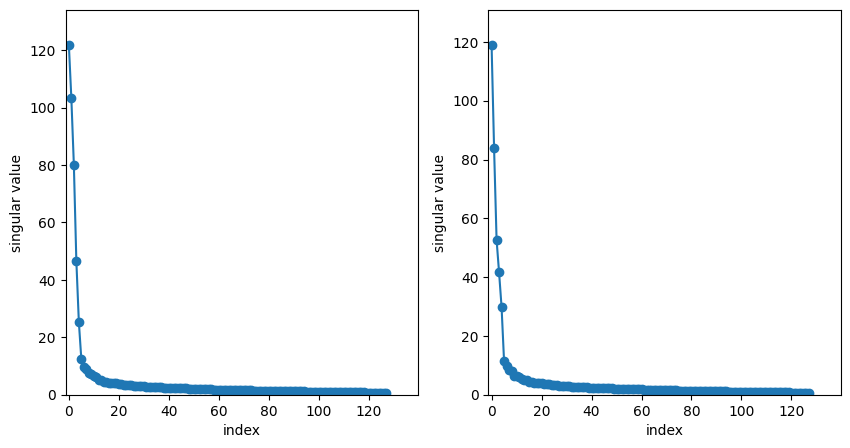

In [6]:
plt.figure(figsize=[10, 5])
plt.subplot(1, 2, 1)
PCA().fit(all_in_features[:,:128]).plot_scree(log = False)
plt.subplot(1, 2, 2)
PCA().fit(all_in_features[:,128:]).plot_scree(log = False)

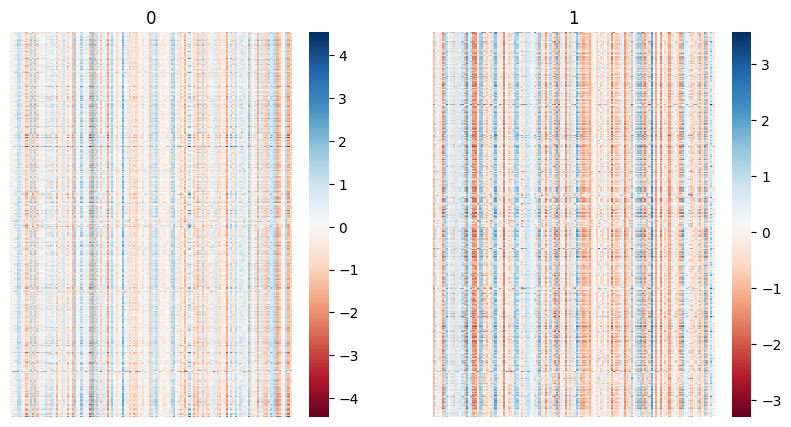

In [7]:
plt.figure(figsize=[10, 5])
data_block_heatmaps([all_in_features[:,:128], all_in_features[:,128:]])


In [7]:
pca=skdim.id.lPCA()
gID1 = pca.fit(all_in_features[:,:128]).dimension_
gID2 = pca.fit(all_in_features[:,128:]).dimension_
print(f'pca ID estimation: {gID1},{gID2}')
est = skdim.id.DANCo()
gID1 = est.fit(all_in_features[:,:128]).dimension_
gID2 = est.fit(all_in_features[:,128:]).dimension_
print(f'DANCo ID estimation: {gID1},{gID2}')


pca ID estimation: 4,5
DANCo ID estimation: 9.060849453770317,10.02391975308642


In [8]:
est = skdim.id.CorrInt()
gID1 = est.fit(all_in_features[:,:128]).dimension_
gID2 = est.fit(all_in_features[:,128:]).dimension_
print(f'CorrInt ID estimation: {gID1},{gID2}')
est = skdim.id.ESS()
gID1 = est.fit(all_in_features[:,:128]).dimension_
gID2 = est.fit(all_in_features[:,128:]).dimension_
print(f'ESS ID estimation: {gID1},{gID2}')

CorrInt ID estimation: 5.459476507659041,5.918827874576795
ESS ID estimation: 6.017871592277889,6.8984551873222975


In [56]:
sorted_indices = np.argsort(all_labels)

# Reorder each array in data_r based on the sorted indices
all_in_features = all_in_features[sorted_indices, :]
all_predictions = all_predictions[sorted_indices]
all_labels = all_labels[sorted_indices]
# Print the bincount of the first 100 labels to verify the grouping
print(np.bincount(all_labels[sorted_indices]))

[1341  467   93   76   23]


In [ ]:
aj = AJIVE(init_signal_ranks=[10,10], n_jobs=16, center=False)
aj.fit([all_in_features[:,:128], all_in_features[:,128:]])
aj.summary()

'AJIVE, joint rank: 5, view 0 indiv rank: 7, view 1 indiv rank: 7'

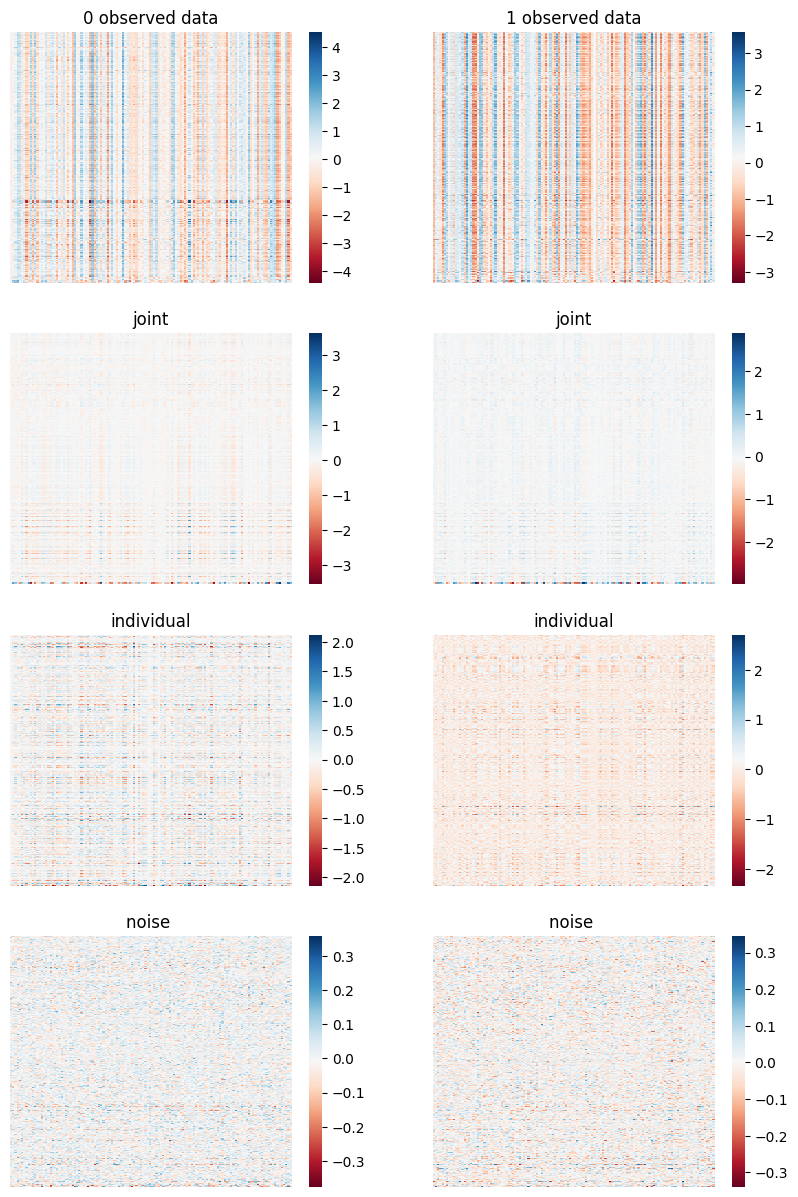

In [93]:
plt.figure(figsize=[10, 15])
jive_full_estimate_heatmaps(aj.get_view_decomps(),blocks=[all_in_features[:,:128], all_in_features[:,128:]])


In [70]:
aj.get_ranks()
centerer = aj.view_specific_[0].individual_.centerer_


In [71]:
aj.common_.transform([all_in_features[:,:128], all_in_features[:,128:]]).shape
aj.common_.views_[0].view_loadings_.shape

(128, 3)

In [72]:
aj.view_specific_[0].individual_.transform(all_in_features[:,:128]).shape

(2000, 7)

In [73]:
a11 = aj.view_specific_[0].joint_.transform(all_in_features[:,:128])
a12 = aj.view_specific_[1].joint_.transform(all_in_features[:,128:])
#a1 = aj.common_.transform([aji[0]['joint'], aji[1]['joint']])
a2 = aj.common_.transform([all_in_features[:,:128], all_in_features[:,128:]])
aj.view_specific_[0].joint_.loadings_.shape
#a1 = a11 + a12
#np.mean(a1)
#aj.view_specific_[0].joint_.loadings_


(128, 3)

In [95]:
A = all_in_features[:,:128]
B = aji[0]['joint']

T = aj.common_.common_norm_scores_
T1 = np.dot(T, T.T)
np.dot(T, np.dot(T.T, A)) - B

T = aj.common_.views_[0].view_loadings_
T1 = np.dot(T, T.T)
np.dot(A, T1)-B
#np.dot(T1, A) - B
#centerer = aj.common_.views_[0].centerer_
#centerer.inverse_transform(r)-B
#aj.common_.common_loadings_[0].shape



array([[ 0.18083085, -0.0402413 , -0.3588107 , ..., -1.1430174 ,
         1.2656537 ,  0.8817512 ],
       [ 0.20078053, -0.04047983, -0.3962886 , ..., -1.2677584 ,
         1.4087894 ,  0.97942215],
       [ 0.18586092, -0.01400831, -0.38623846, ..., -1.189994  ,
         1.3292636 ,  0.84548116],
       ...,
       [ 0.16383193, -0.5869464 , -1.0591296 , ..., -1.5172957 ,
         0.64499885, -0.27333897],
       [ 0.20020875,  0.1153661 , -0.7405698 , ..., -1.5331866 ,
         1.5907842 ,  0.11523011],
       [ 0.18477985, -0.12235851, -0.47631022, ..., -1.2403094 ,
         1.2194698 ,  0.7401118 ]], dtype=float32)

In [96]:
aji = aj.get_view_decomps()
J = aji[0]['joint']
I = aji[0]['individual']
N = aji[0]['noise']
comb =  J + I + N
comb = centerer.inverse_transform(comb)
sum(sum(np.abs(comb - all_in_features[:,:128])))/256000

np.float32(0.6504204)

# Assesing classification on different representations of data

In [76]:
from sklearn.metrics import accuracy_score, f1_score

print(f'accuracy for original network classification: {f1_score(all_labels, all_predictions, average="macro")}')

accuracy for original network classification: 0.4389980891482148


In [97]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import balanced_accuracy_score, f1_score
from imblearn.over_sampling import SMOTE

# Cross-validation with KNN
def cross_val_knn(X, y, n_neighbors=5, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    results = []

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Handle class imbalance using SMOTE
        smote = SMOTE()
        X_train, y_train = smote.fit_resample(X_train, y_train)

        # Apply KNN classifier
        knn = KNeighborsClassifier(n_neighbors=n_neighbors)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)

        # Calculate balanced accuracy score
        acc = f1_score(y_test, y_pred, average='macro')   
        results.append(acc)
    
    return np.mean(results)


In [98]:
X0 = all_in_features
X1 = all_in_features[:,:128]
X2 = all_in_features[:,128:]
X3 = aj.common_.transform([X1, X2])
X4 = np.concat((aj.view_specific_[0].joint_.transform(X1), aj.view_specific_[1].joint_.transform(X2)), axis=1)
X5 = aj.view_specific_[0].joint_.transform(X1)
X6 = aj.view_specific_[1].joint_.transform(X2)
X7 = np.concat((aj.view_specific_[0].individual_.transform(X1), aj.view_specific_[1].individual_.transform(X2)), axis=1)
X8 = np.concat((X4, X7), axis=1)
data = ['both views','CC view', 'MLO view', 'Common Joint 3 dim', 'Ajive Joint', 'AJIVE CC joint', 'AJIVE MLO joint', 'AJIVE both individual', 'AJIVE joint + individual']
y = all_labels


In [99]:
n_neigh = 10
res0 = cross_val_knn(X0, y, n_neighbors=n_neigh, n_splits=5)
res1 = cross_val_knn(X1, y, n_neighbors=n_neigh, n_splits=5)
res2  = cross_val_knn(X2, y, n_neighbors=n_neigh, n_splits=5)
res3  = cross_val_knn(X3, y, n_neighbors=n_neigh, n_splits=5)
res4  = cross_val_knn(X4, y, n_neighbors=n_neigh, n_splits=5)
res5  = cross_val_knn(X5, y, n_neighbors=n_neigh, n_splits=5)
res6  = cross_val_knn(X6, y, n_neighbors=n_neigh, n_splits=5)
res7  = cross_val_knn(X7, y, n_neighbors=n_neigh, n_splits=5)
res8  = cross_val_knn(X8, y, n_neighbors=n_neigh, n_splits=5)
for i, res in enumerate([res0, res1, res2, res3, res4, res5, res6, res7, res8]):
    print(f'Balanced accuracy for {data[i]}: {res}')


Balanced accuracy for both views: 0.3302359466013618
Balanced accuracy for CC view: 0.3017741351346389
Balanced accuracy for MLO view: 0.3158833656895216
Balanced accuracy for Common Joint 3 dim: 0.35672807741602097
Balanced accuracy for Ajive Joint: 0.34372824982484373
Balanced accuracy for AJIVE CC joint: 0.31434707783684807
Balanced accuracy for AJIVE MLO joint: 0.3288265829024505
Balanced accuracy for AJIVE both individual: 0.3354110940514948
Balanced accuracy for AJIVE joint + individual: 0.3388262043628768


# Figuring out how to saliency map

In [4]:
def saliency_map(model, x, plot=True):
    """
    Computes the saliency map of an input sample with respect to the predicted class. 
    
    Parameters:
        model (torch.nn.Module): Trained model.
        x (list): List of input samples from Breast_Cancer_Dataloader.
        plot (bool): Whether to plot the saliency map. 
        
    Returns:
        saliency (list): List of saliency maps.
        target_class (int): Predict
    """
    x = [item.to('mps') for item in x]
    model.to('mps')
    for i in range(2):
        x[i] = x[i].unsqueeze(0)
        x[i].requires_grad = True

    output = model(x)
    target_class = output.argmax(dim=1)

    model.zero_grad()
    output[0, target_class].backward()
    saliency = [sample.grad.abs().max(dim=1)[0].squeeze().cpu().numpy() for sample in x]
    
    if plot:
        fig, axs = plt.subplots(2, 2)
        for i in range(2):
            axs[0, i].imshow(x[i].cpu().detach().numpy()[0,0,:,:], cmap='gray')
            axs[0, i].set_title(f'view: {'CC' if i == 0 else 'MLO'}')
            axs[0, i].axis('off')
            axs[1, i].imshow(saliency[i], cmap='hot')
            axs[1, i].set_title(f"y=: , y_hat: {target_class.item()}")
            axs[1, i].axis('off')

    
    return saliency, target_class.item()

def overlay_saliency_on_image(image, saliency, alpha=0.5, colormap=cv2.COLORMAP_JET, plot=True):
    """
    Overlays a saliency map on an image.
    
    Parameters:
        image (np.ndarray/torch.Tensor): Image.
        saliency (np.ndarray/torch.Tensor): Saliency map.
        alpha (float): Transparency of the heatmap (0 = only image, 1 = only heatmap).
        colormap (int): OpenCV colormap (e.g., cv2.COLORMAP_JET).
        plot (bool): Whether to plot the overlayed image.
        
    Returns:
        image (np.ndarray): Original image.
        overlayed_img (np.ndarray): Overlayed image.
    """

    if isinstance(saliency, torch.Tensor):
        saliency = saliency.cpu().detach().numpy()  # Convert PyTorch tensor to NumPy
    if isinstance(image, torch.Tensor):
        image = image.cpu().detach().numpy()  # Convert PyTorch tensor to NumPy
    elif isinstance(image, torchvision.tv_tensors._image.Image):
        image = np.array(image)  # Convert torchvision Image to NumPy

    # Normalize saliency map to range [0, 255]
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())  # Normalize to [0,1]
    saliency = (saliency * 255).astype(np.uint8)  # Scale to [0,255]

    heatmap = saliency
    # Apply a colormap to make the saliency map visually interpretable
    heatmap = cv2.applyColorMap(saliency, colormap)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2GRAY)  # Convert OpenCV BGR to grayscale

    # Convert grayscale image to 3-channel for blending
    if len(image.shape) == 3:  
        image = image[0]
    image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0,1]
    image = (image * 255).astype(np.uint8)
       
    # Blend the heatmap with the original image
    overlayed_img = cv2.addWeighted(image, 1 - alpha, heatmap, alpha, 0)

    if plot:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        plt.title('Image')
        plt.subplot(1, 2, 2)
        plt.imshow(overlayed_img, cmap='jet')
        plt.axis('off')
        plt.title('Overlayed Image')
        plt.show()  
    
    return image, overlayed_img

def overlay_saliency_on_pair(model, dataloader, split, idx, alpha=0.5, colormap=cv2.COLORMAP_JET, plot=True):
    """
    Overlays saliency maps on a pair of images from a dataloader.
    
    Parameters:
        model (torch.nn.Module): Trained model.
        dataloader (Breast_Cancer_Dataloader): Breast cancer dataloader.
        split (str): Dataset split ('train', 'val', 'test').
        idx (int): Index of the image pair.
        alpha (float): Transparency of the heatmap (0 = only image, 1 = only heatmap).
        colormap (int): OpenCV colormap (e.g., cv2.COLORMAP_JET).
        plot (bool): Whether to plot the overlayed images.
        
    Returns:
        images (list): List of original images.
        saliencies (list): List of saliency maps.
        overlayed_imgs (list): List of overlayed images.    
    """
    if split == 'train':
        images, y = dataloader.train_dataset[idx]
    elif split =='val':
        images, y = dataloader.val_dataset[idx]
    elif split == 'test':
        images, y = dataloader.test_dataset[idx]
    
    saliencies, y_hat = saliency_map(model, images, plot=False)
    
    results = []
    for image, saliency in zip(images, saliencies):
        results.append(overlay_saliency_on_image(image, saliency, alpha, colormap, plot=False))
    images, overlayed_imgs = zip(*results)
    # plot both overlayed saliency maps next to the original images
    if plot:
        fig, axs = plt.subplots(3, 2, figsize=(10, 15))
        for i in range(2):
            axs[0, i].imshow(images[i], cmap='gray')
            axs[0, i].set_title(f'view: {'CC' if i == 0 else 'MLO'}')
            axs[0, i].axis('off')
            axs[1, i].imshow(saliencies[i], cmap='hot')
            axs[1, i].set_title('pure saliency map')
            axs[1, i].axis('off')
            axs[2, i].imshow(overlayed_imgs[i], cmap='jet')
            axs[2, i].set_title(f"y=: {y}, y_hat: {y_hat}")
            axs[2, i].axis('off')
    return images, saliencies, overlayed_imgs
    


In [136]:
print(np.where(all_predictions==4))
print(np.where(all_labels==4))
all_labels[np.where(all_predictions==4)]

(array([ 493,  765,  768,  886,  890,  894,  976,  979,  980,  986, 1211,
       1542, 1763, 1964, 1974, 1978, 1984]),)
(array([ 152,  515,  700,  765,  766,  768,  894,  902,  980,  981,  985,
        986,  988, 1123, 1211, 1542, 1763, 1844, 1884, 1889, 1964, 1978,
       1984]),)


array([2, 4, 4, 3, 3, 4, 3, 3, 4, 4, 4, 4, 4, 4, 3, 4, 4])

In [37]:
print(np.where((all_predictions==3)&(all_labels==0)))

(array([754, 983, 994, 996]),)


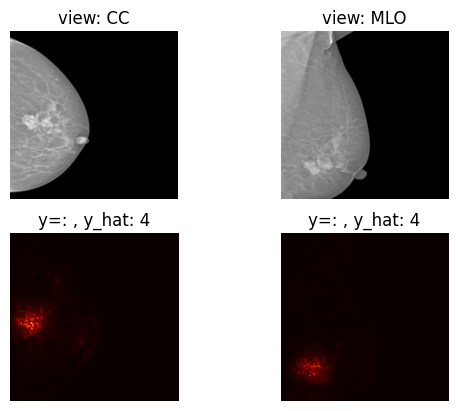

In [106]:
saliency = saliency_map(model, breast_loader.test_dataset[894][0])

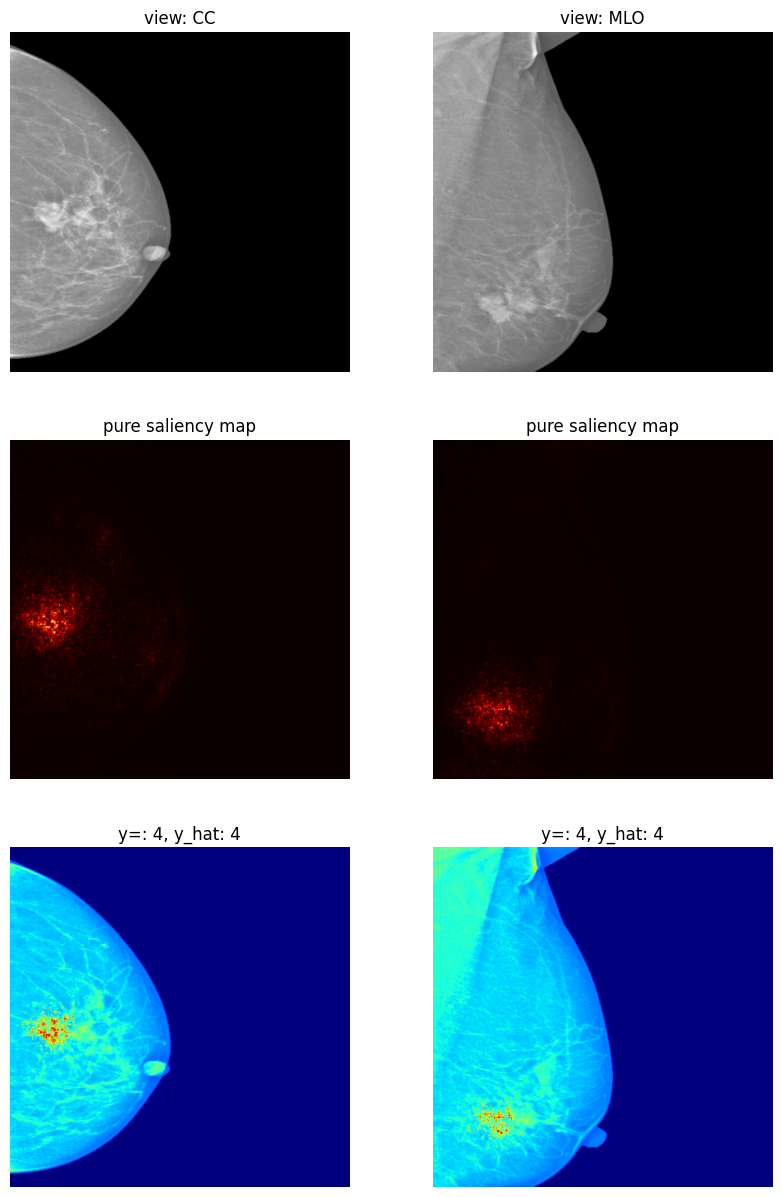

In [5]:
images, saliencies, overlayed_imgs = overlay_saliency_on_pair(model, breast_loader, 'test', 894, alpha=0.5, colormap=cv2.COLORMAP_JET)

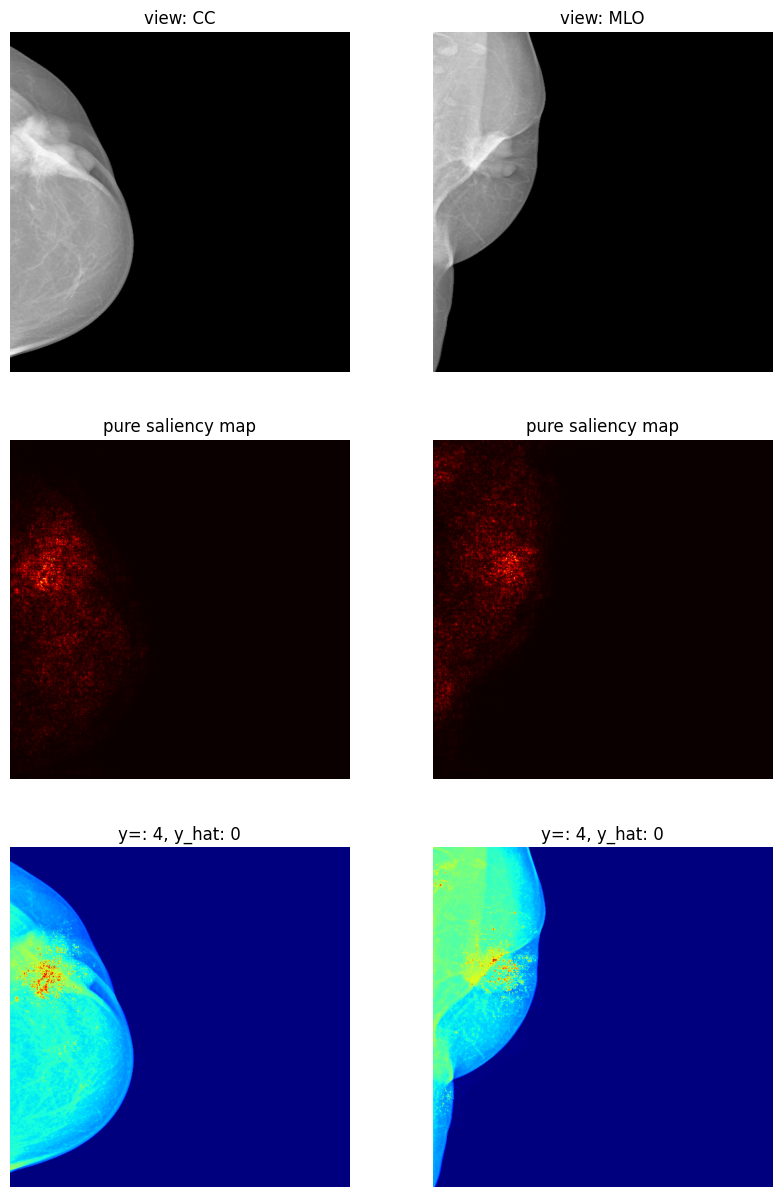

In [50]:
images, saliencies, overlayed_imgs = overlay_saliency_on_pair(model, breast_loader, 'test', 515, alpha=0.5, colormap=cv2.COLORMAP_JET)

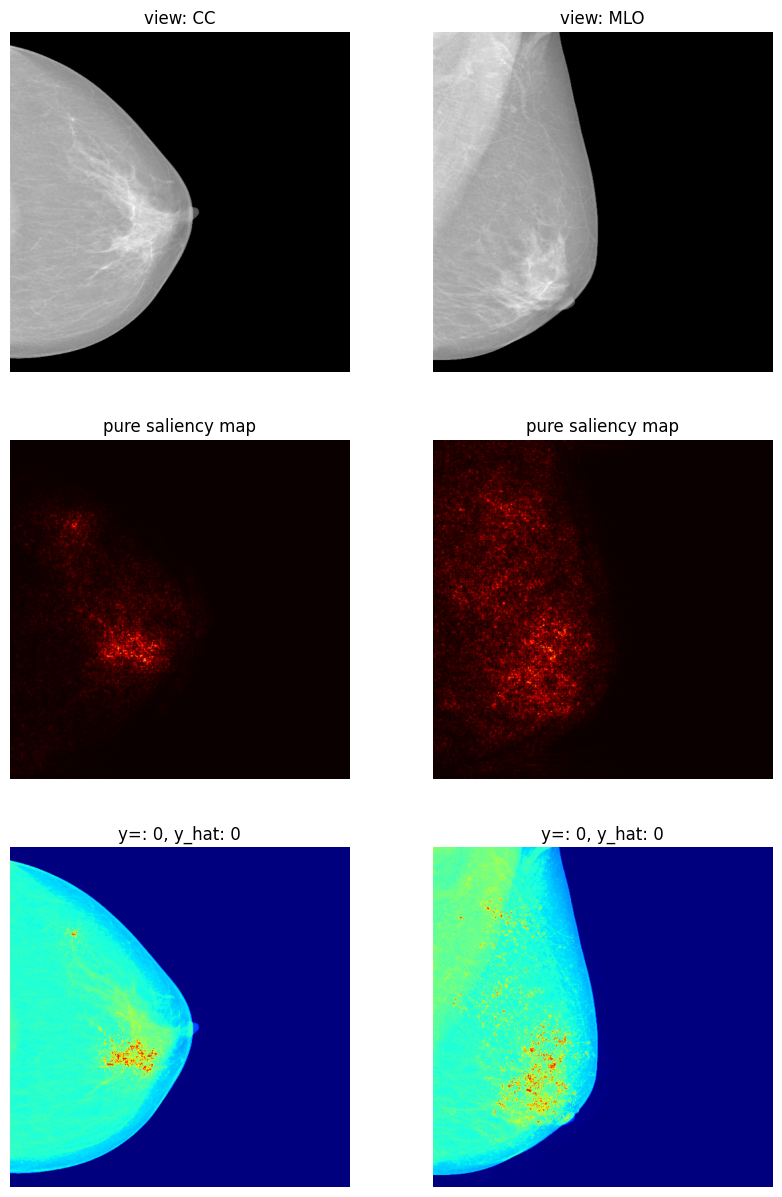

In [51]:
images, saliencies, overlayed_imgs = overlay_saliency_on_pair(model, breast_loader, 'test', 0, alpha=0.5, colormap=cv2.COLORMAP_JET)

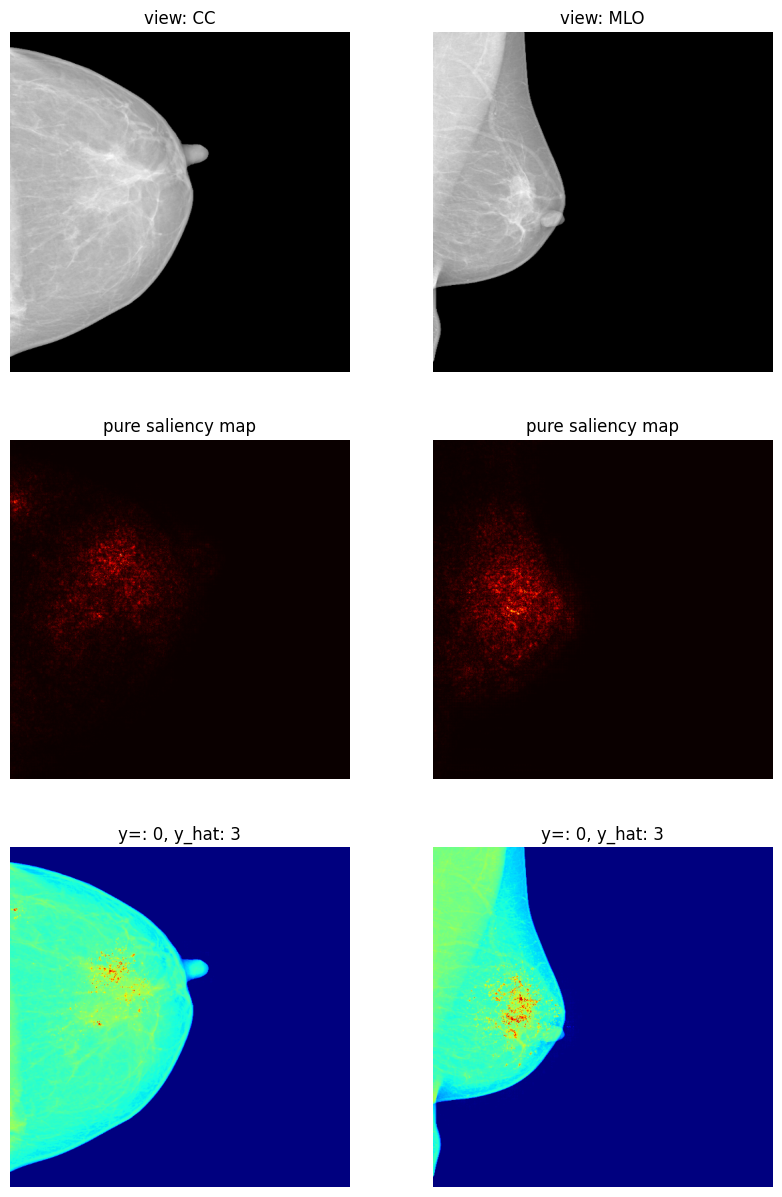

In [38]:
images, saliencies, overlayed_imgs = overlay_saliency_on_pair(model, breast_loader, 'test', 754, alpha=0.5, colormap=cv2.COLORMAP_JET)